In [1]:
import pandas as pd
import numpy as np
import qiskit.pulse as pulse
from qiskit.circuit import Parameter
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit import schedule
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend

In [2]:
backend = SingleTransmonTestBackend(5.2e9,-.25e9, 1e9, 0.8e9, noise=False, seed=100)
qubit = 0
cals=Calibrations.from_backend(backend)
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
Multi qubit instructions:
)>


In [3]:
# A function to instantiate calibrations and add a couple of template schedules.
def setup_cals(backend) -> Calibrations:

    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp, num_qubits=1)
    cals.add_schedule(xm, num_qubits=1)
    cals.add_schedule(x90p, num_qubits=1)

    return cals

# Add guesses for the parameter values to the calibrations.
def add_parameter_guesses(cals: Calibrations):

    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

In [4]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

In [5]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = Calibrations.from_backend(backend, libraries=[library])
print(library.default_values()) # check what parameter values this library has
print(cals.get_inst_map()) # check the new cals's InstructionScheduleMap made from the library
print(cals.get_schedule('x',(0,))) # check one of the schedules built from the new calibration

[DefaultCalValue(value=80.0, parameter='σ', qubits=(), schedule_name='x'), DefaultCalValue(value=0.5, parameter='amp', qubits=(), schedule_name='x'), DefaultCalValue(value=320, parameter='duration', qubits=(), schedule_name='x'), DefaultCalValue(value=0.0, parameter='β', qubits=(), schedule_name='x'), DefaultCalValue(value=0.0, parameter='β', qubits=(), schedule_name='sx'), DefaultCalValue(value=0.25, parameter='amp', qubits=(), schedule_name='sx'), DefaultCalValue(value=80.0, parameter='σ', qubits=(), schedule_name='sx'), DefaultCalValue(value=320, parameter='duration', qubits=(), schedule_name='sx')]
<InstructionScheduleMap(1Q instructions:
  q0: {'x', 'sx', 'y', 'sy'}
Multi qubit instructions:
)>
ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0, amp=0.5, angle=0), DriveChannel(0)), name="x", transform=AlignLeft())


In [6]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

In [7]:
# dataframe styling
pd.set_option('display.precision', 5)
pd.set_option('display.html.border', 1)
pd.set_option('display.max_colwidth', 24)

In [8]:
columns_to_show = ["parameter", "qubits", "schedule", "value", "date_time"]
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()]))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,amp,(),sx,2.50000e-01,2023-07-11 17:45:42....
1,β,(),x,0.00000e+00,2023-07-11 17:45:42....
2,σ,(),sx,8.00000e+01,2023-07-11 17:45:42....
3,drive_freq,"(0,)",None,5.20000e+09,2023-07-11 17:45:42....
4,duration,(),x,3.20000e+02,2023-07-11 17:45:42....
5,duration,(),sx,3.20000e+02,2023-07-11 17:45:42....
6,β,(),sx,0.00000e+00,2023-07-11 17:45:42....
7,meas_freq,"(0,)",None,0.00000e+00,2023-07-11 17:45:42....
8,amp,(),x,5.00000e-01,2023-07-11 17:45:42....
9,σ,(),x,8.00000e+01,2023-07-11 17:45:42....


In [9]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate-15e6, freq01_estimate+15e6, 51)
spec = RoughFrequencyCal([qubit], cals, frequencies, backend=backend)
spec.set_experiment_options(amp=0.005)

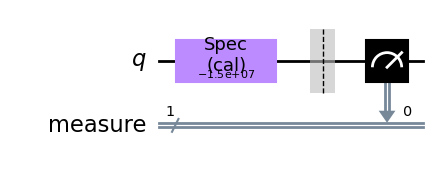

In [10]:
circuit = spec.circuits()[0]
circuit.draw(output="mpl")

In [11]:
next(iter(circuit.calibrations["Spec"].values())).draw()
circuit.calibrations["Spec"]

{((0,),
  (-15000000.0,)): ScheduleBlock(ShiftFrequency(-15000000, DriveChannel(0)), Play(GaussianSquare(duration=2400, sigma=599.9999999999999, width=0.0, amp=0.005, angle=0), DriveChannel(0)), ShiftFrequency(15000000, DriveChannel(0)), name="spectroscopy", transform=AlignLeft())}

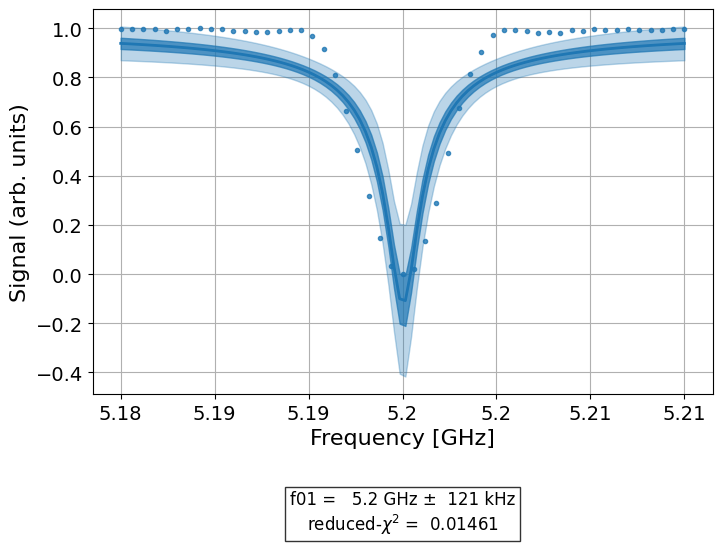

In [12]:
spec_data = spec.run().block_for_results()
spec_data.figure(0)

In [13]:
print(spec_data.analysis_results("f01"))

AnalysisResult
- name: f01
- value: (5.20002+/-0.00012)e+09
- χ²: 0.014607554567779667
- quality: good
- extra: <1 items>
- device_components: ['Q0']
- verified: False


In [14]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit]))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,drive_freq,"(0,)",None,5.20002e+09,2023-07-11 17:47:07....
1,meas_freq,"(0,)",None,0.00000e+00,2023-07-11 17:45:42....


In [15]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal
rabi = RoughXSXAmplitudeCal((qubit,), cals, backend=backend, amplitudes=np.linspace(-0.1, 0.1, 51))

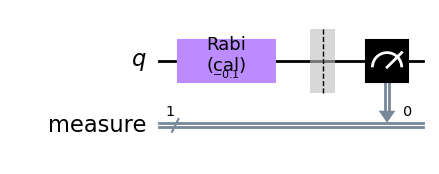

In [16]:
rabi.circuits()[0].draw("mpl")

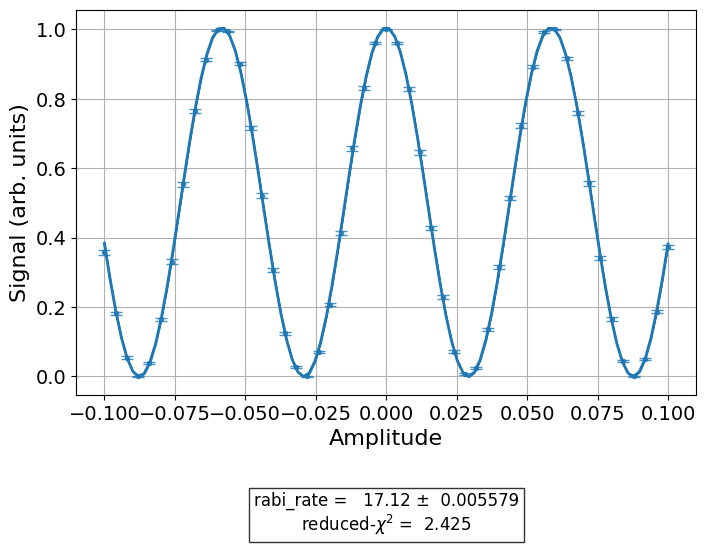

In [17]:
rabi_data = rabi.run().block_for_results()
rabi_data.figure(0)

In [18]:
print(rabi_data.analysis_results("rabi_rate"))

AnalysisResult
- name: rabi_rate
- value: 17.115+/-0.006
- χ²: 2.4247149251905356
- quality: bad
- device_components: ['Q0']
- verified: False


In [19]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,amp,"(0,)",sx,0.01461+0.00000j,2023-07-11 17:47:41....
1,amp,"(0,)",x,0.02921+0.00000j,2023-07-11 17:47:41....
2,amp,(),x,0.50000+0.00000j,2023-07-11 17:45:42....
3,amp,(),sx,0.25000+0.00000j,2023-07-11 17:45:42....


In [20]:
cals.get_schedule("sx", qubit)

ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0, amp=0.01460694, angle=0), DriveChannel(0)), name="sx", transform=AlignLeft())

In [21]:
cals.get_schedule("x", qubit)

ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0, amp=0.02921388, angle=0), DriveChannel(0)), name="x", transform=AlignLeft())

In [22]:
cals.get_schedule("y", qubit)

ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0, amp=0.02921388j, angle=0), DriveChannel(0)), name="y", transform=AlignLeft())

In [ ]:
cals.save(file_type="csv", overwrite=True, file_prefix="PulseBackend")

In [ ]:
cals = Calibrations.from_backend(backend, library)
cals.load_parameter_values(file_name="PulseBackendparameter_values.csv")

In [23]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,amp,"(0,)",sx,0.01461+0.00000j,2023-07-11 17:47:41....
1,amp,"(0,)",x,0.02921+0.00000j,2023-07-11 17:47:41....
2,amp,(),x,0.50000+0.00000j,2023-07-11 17:45:42....
3,amp,(),sx,0.25000+0.00000j,2023-07-11 17:45:42....


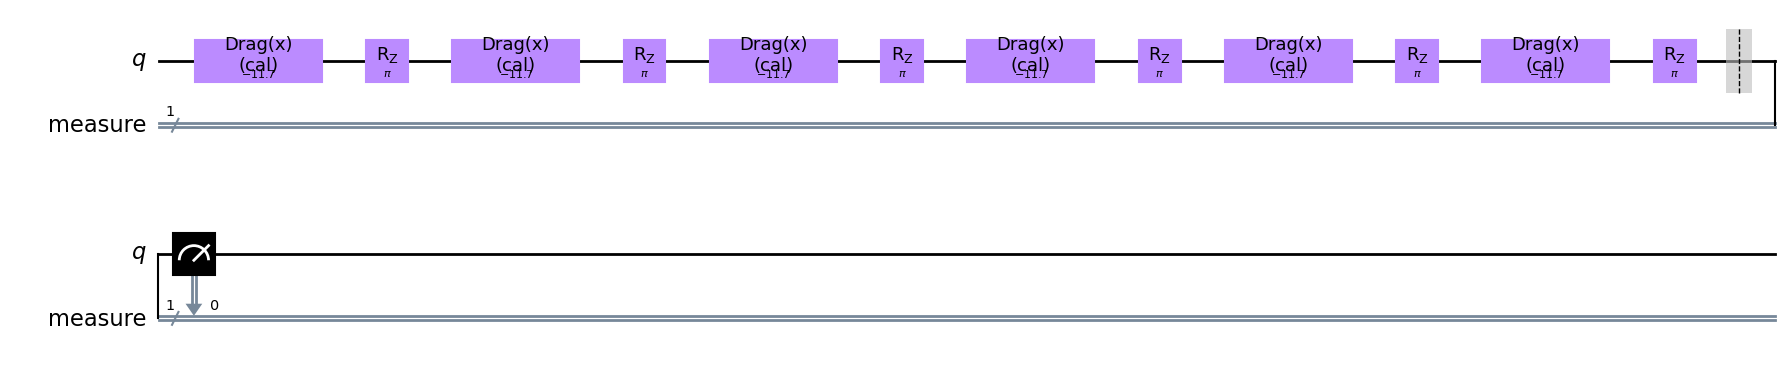

In [24]:
from qiskit_experiments.library import RoughDragCal
cal_drag = RoughDragCal([qubit], cals, backend=backend, betas=np.linspace(-20, 20, 25))
cal_drag.set_experiment_options(reps=[3, 5, 7])
cal_drag.circuits()[5].draw(output='mpl')

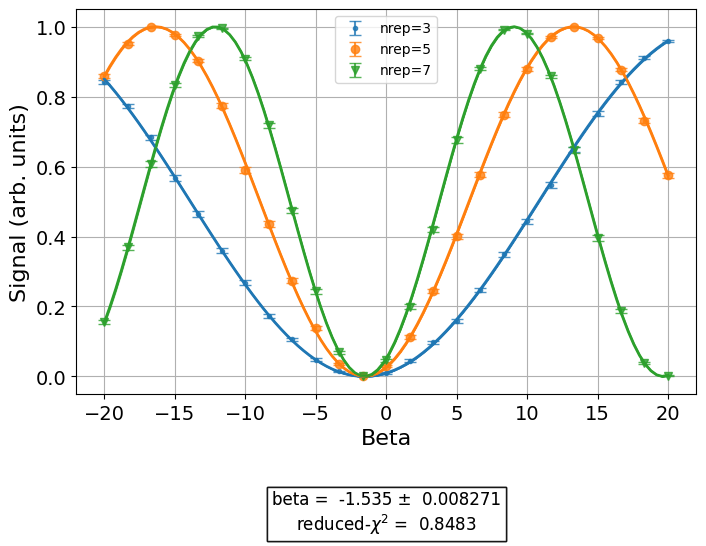

In [25]:
drag_data = cal_drag.run().block_for_results()
drag_data.figure(0)

In [26]:
print(drag_data.analysis_results("beta"))

AnalysisResult
- name: beta
- value: -1.535+/-0.008
- χ²: 0.8482647032520693
- quality: bad
- device_components: ['Q0']
- verified: False


In [27]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="β"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,β,(),x,0.00000,2023-07-11 17:45:42....
1,β,"(0,)",x,-1.53491,2023-07-11 17:48:20....
2,β,(),sx,0.00000,2023-07-11 17:45:42....


In [28]:
from qiskit.pulse import InstructionScheduleMap
from qiskit_experiments.library import FineXAmplitude

In [29]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
d0, inst_map = pulse.DriveChannel(qubit), pulse.InstructionScheduleMap()

In [30]:
ideal_amp = x_pulse.amp
over_amp = ideal_amp*1.02
under_amp = ideal_amp*0.98
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f} which we set as ideal_amp.")
print(f"we use {over_amp:.4f} amplitude for overroation pulse and {under_amp:.4f} for underrotation pulse.")
# build the over rotated pulse and add it to the instruction schedule map
with pulse.build(backend=backend, name="x") as x_over:
    pulse.play(pulse.Drag(x_pulse.duration, over_amp, x_pulse.sigma, x_pulse.beta), d0)
inst_map.add("x", (qubit,), x_over)

The reported amplitude of the X pulse is 0.0582 which we set as ideal_amp.
we use 0.0594 amplitude for overroation pulse and 0.0570 for underrotation pulse.


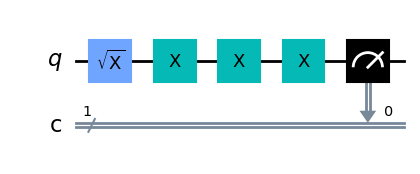

In [31]:
overamp_exp = FineXAmplitude(qubit, backend=backend)
overamp_exp.set_transpile_options(inst_map=inst_map)
overamp_exp.circuits()[4].draw(output='mpl')

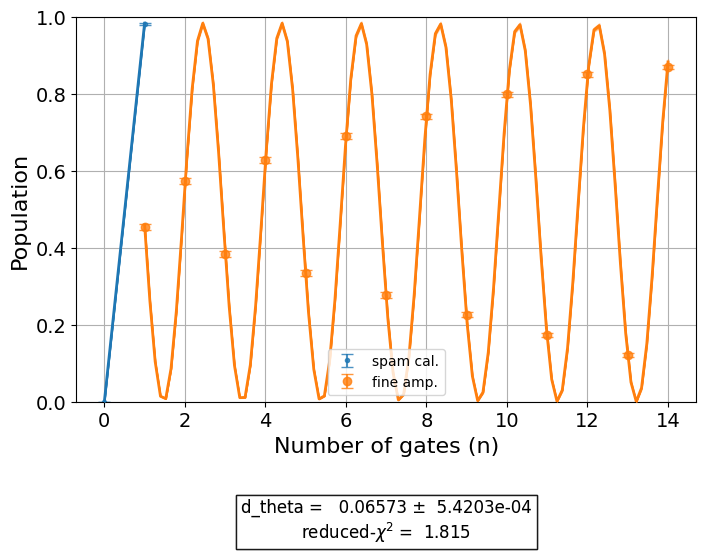

In [32]:
# do the experiment
exp_data_over = overamp_exp.run(backend).block_for_results()
exp_data_over.figure(0)

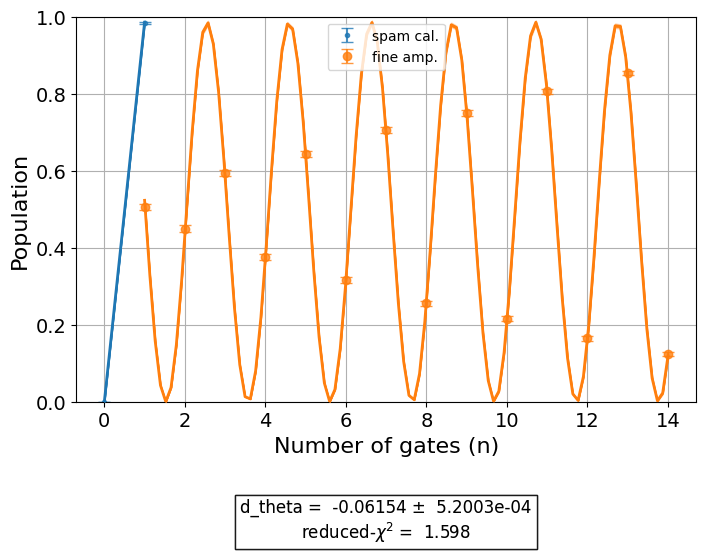

In [33]:
# build the under rotated pulse and add it to the instruction schedule map
with pulse.build(backend=backend, name="x") as x_under:
    pulse.play(pulse.Drag(x_pulse.duration, under_amp, x_pulse.sigma, x_pulse.beta), d0)
inst_map.add("x", (qubit,), x_under)

# do the experiment
underamp_exp = FineXAmplitude(qubit, backend=backend)
underamp_exp.set_transpile_options(inst_map=inst_map)

exp_data_under = underamp_exp.run(backend).block_for_results()
exp_data_under.figure(0)

In [34]:
# analyze the results
target_angle = np.pi
dtheta_over = exp_data_over.analysis_results("d_theta").value.nominal_value
scale_over = target_angle / (target_angle + dtheta_over)
dtheta_under = exp_data_under.analysis_results("d_theta").value.nominal_value
scale_under = target_angle / (target_angle + dtheta_under)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta_over:.3f} rad in over-rotated pulse case.")
print(f"Thus, scale the {over_amp:.4f} pulse amplitude by {scale_over:.3f} to obtain {over_amp*scale_over:.5f}.")
print(f"On the other hand, we measued a deviation of {dtheta_under:.3f} rad in under-rotated pulse case.")
print(f"Thus, scale the {under_amp:.4f} pulse amplitude by {scale_under:.3f} to obtain {under_amp*scale_under:.5f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.066 rad in over-rotated pulse case.
Thus, scale the 0.0594 pulse amplitude by 0.980 to obtain 0.05816.
On the other hand, we measued a deviation of -0.062 rad in under-rotated pulse case.
Thus, scale the 0.0570 pulse amplitude by 1.020 to obtain 0.05819.


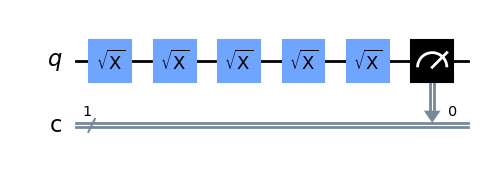

In [35]:
from qiskit_experiments.library import FineSXAmplitudeCal

amp_cal = FineSXAmplitudeCal([qubit], cals, backend=backend, schedule_name="sx")
amp_cal.circuits()[4].draw(output="mpl")

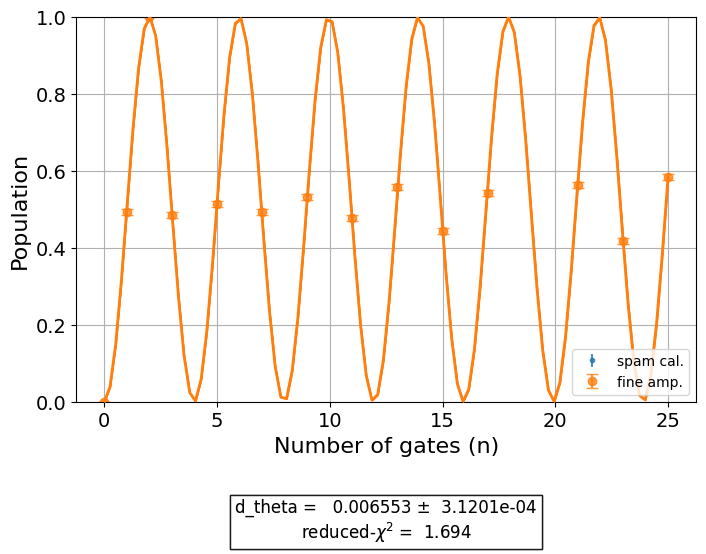

In [36]:
exp_data_x90p = amp_cal.run().block_for_results()
exp_data_x90p.figure(0)

In [37]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,amp,"(0,)",sx,0.01455+0.00000j,2023-07-11 17:48:25....
1,amp,"(0,)",x,0.02921+0.00000j,2023-07-11 17:47:41....
2,amp,(),x,0.50000+0.00000j,2023-07-11 17:45:42....
3,amp,(),sx,0.25000+0.00000j,2023-07-11 17:45:42....


In [38]:
cals.get_schedule("sx", qubit)

ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0, amp=0.0145462552, angle=0), DriveChannel(0)), name="sx", transform=AlignLeft())

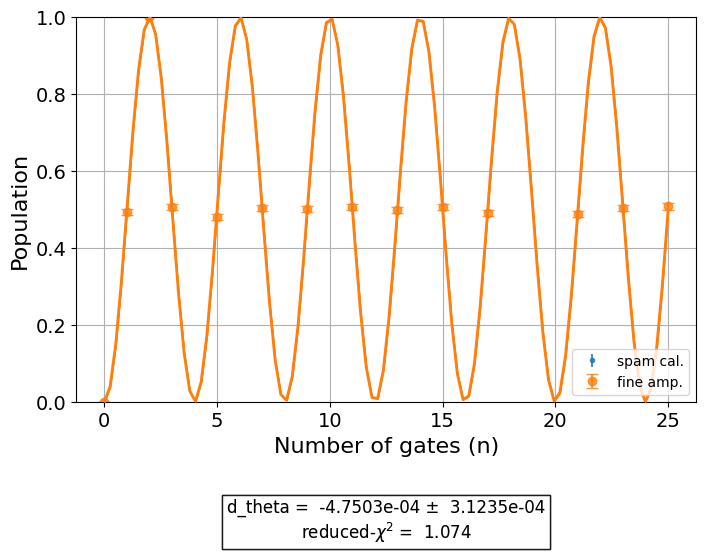

In [39]:
exp_data_x90p_rerun = amp_cal.run().block_for_results()
exp_data_x90p_rerun.figure(0)